In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16


Using Theano backend.


In [3]:
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense,Flatten, Activation,Dropout
from keras.callbacks import EarlyStopping, History


In [4]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split

In [5]:
datagen = ImageDataGenerator(rescale=1., featurewise_center=True) #(rescale=1./255)
datagen.mean=np.array([103.939, 116.779, 123.68],dtype=np.float32).reshape(3,1,1) # VGG processing

In [6]:
train_dir = "train/train/"
test_dir = "test_stg1/"

In [7]:
nb_train_samples = 3777
nb_test_samples = 1000


In [8]:
model = VGG16(weights = "imagenet", include_top = False)

In [8]:
train_generator = datagen.flow_from_directory(
            train_dir,
            target_size=(150,150),
            batch_size=32,
            class_mode=None,
            shuffle=False)

bottleneck_features_train = model.predict_generator(train_generator, nb_train_samples)
np.save('bottleneck_features_train.npy', bottleneck_features_train)



Found 3777 images belonging to 8 classes.


In [9]:
classes = os.listdir(train_dir)
labels = []
for fish in classes:
    label_list = [fish]*len(os.listdir(train_dir+fish+'/'))
    labels.extend(label_list)

In [12]:
train_labels = LabelEncoder().fit_transform(labels)
train_labels = np_utils.to_categorical(train_labels)

In [13]:
train_data = np.load("bottleneck_features_train.npy")

In [17]:
top_model = Sequential()
top_model.add(Flatten(input_shape=train_data.shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(64, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(8, activation='softmax'))


In [26]:

top_model.compile(optimizer="adam",loss="categorical_crossentropy",metrics =["accuracy"])

In [27]:
callbacks = EarlyStopping(monitor='val_loss', patience=4, verbose=1, mode='auto')        


In [29]:
history = top_model.fit(train_data, train_labels, batch_size=32, nb_epoch=90,
              validation_split=0.4,shuffle=True,callbacks = [callbacks])

Train on 2266 samples, validate on 1511 samples
Epoch 1/90
2266/2266 [==============================] - 1s - loss: 3.8908 - acc: 0.7586 - val_loss: 16.1181 - val_acc: 0.0000e+00
Epoch 2/90
2266/2266 [==============================] - 1s - loss: 3.8908 - acc: 0.7586 - val_loss: 16.1181 - val_acc: 0.0000e+00
Epoch 3/90
2266/2266 [==============================] - 1s - loss: 3.8908 - acc: 0.7586 - val_loss: 16.1181 - val_acc: 0.0000e+00
Epoch 4/90
2266/2266 [==============================] - 1s - loss: 3.8908 - acc: 0.7586 - val_loss: 16.1181 - val_acc: 0.0000e+00
Epoch 5/90
2266/2266 [==============================] - 1s - loss: 3.8908 - acc: 0.7586 - val_loss: 16.1181 - val_acc: 0.0000e+00
Epoch 6/90
2266/2266 [==============================] - 1s - loss: 3.8908 - acc: 0.7586 - val_loss: 16.1181 - val_acc: 0.0000e+00
Epoch 00005: early stopping


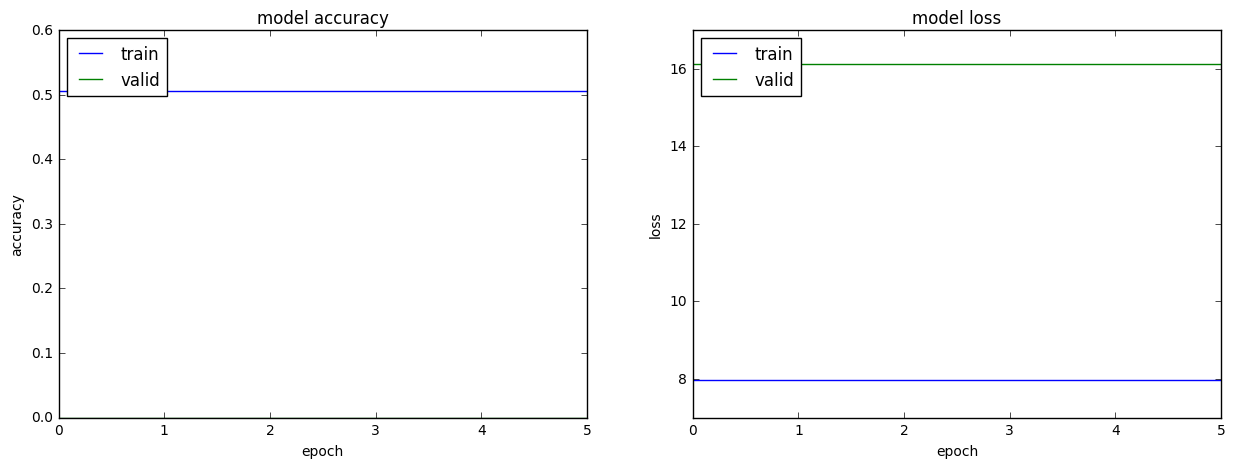

In [22]:
# summarize history for accuracy
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['acc']); plt.plot(history.history['val_acc']);
plt.title('model accuracy'); plt.ylabel('accuracy');
plt.xlabel('epoch'); plt.legend(['train', 'valid'], loc='upper left');

# summarize history for loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss']); plt.plot(history.history['val_loss']);
plt.title('model loss'); plt.ylabel('loss');
plt.xlabel('epoch'); plt.legend(['train', 'valid'], loc='upper left');
plt.show()

In [63]:
test_generator = datagen.flow_from_directory(
            test_dir,
            target_size=(150,150),
            batch_size=5,
            class_mode=None,
            shuffle=False)

bottleneck_features_test = model.predict_generator(test_generator,nb_test_samples)

Found 1000 images belonging to 1 classes.


In [60]:
top_model.save_weights("bottleneck_train_no_augmentation.h5")

In [64]:
np.save("bottleneck_test_features_no_top.npy",bottleneck_features_test)

In [65]:
test_preds = top_model.predict(bottleneck_features_test, verbose=1)

 992/1000 [============================>.] - ETA: 0s

In [69]:
submission = pd.DataFrame(test_preds, columns= os.listdir(train_dir))
test_files = os.listdir("test_stg1/test_stg1/")
submission.insert(0, 'image', test_files)
submission.head()

,image,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT
0,img_00005.jpg,8.333322e-30,9.545717e-29,4.708363e-43,0.000000e+00,1.000000e+00,3.473940e-29,3.974082e-41,8.173325e-30
1,img_00007.jpg,1.000000e+00,7.266771e-20,1.591903e-18,8.671401e-15,4.043013e-18,4.578993e-14,2.503016e-21,7.221993e-15
2,img_00009.jpg,1.000000e+00,5.585097e-12,9.408476e-16,6.727845e-13,4.981282e-13,9.942670e-10,1.819449e-15,7.382608e-14
3,img_00018.jpg,9.999950e-01,5.509736e-08,3.668536e-10,8.235089e-09,8.963706e-09,4.460130e-06,2.414648e-09,4.766436e-07
4,img_00027.jpg,9.846449e-01,2.484199e-04,1.449984e-04,5.678083e-05,4.407049e-04,1.857326e-03,6.283631e-03,6.323206e-03


In [75]:
submission.to_csv("bottleneck_pred.csv",index = False)